In [ ]:
!pip install lime
import pandas as pd
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 13.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=16211eb38ac14c4def0a70c6dbae590269fc03c9e45321d29bb7fca9d989665d
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_credit = pd.read_csv('/content/drive/MyDrive/PG32 CS3244/credit_record.csv')
df_application = pd.read_csv('/content/drive/MyDrive/PG32 CS3244/application_record.csv')

In [ ]:
df_credit.info()
df_application.info()

# The total rows are 438,557. This means it has duplicate IDs, should be removed
print(df_application['ID'].nunique())
# Drop duplicate
df_application_clean = df_application.drop_duplicates('ID', keep='last')


# Total rows are 1048575, for each customer, there is record for each month since opening of the account,
# And STATUS indicating whether the customer is in debt that month
print(df_credit['ID'].nunique()) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-

In [ ]:
# only run this block once!!! Otherwise need to reload the data

# see the number of overdue status
df_credit['STATUS'].value_counts() 

# replace the value C and X with 0 as it is the same type (not risky)
df_credit['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)

# change all the values to int so that I can do filtering later
df_credit['STATUS'] = df_credit['STATUS'].astype('int')

# 2,3,4,5 are classified as 1 because they are the same type, overdue for more than 60 days
# 0&1 also to be 0 because not so much overdue
# these will be our labels/prediction results for our model, bad=1,good=0
df_credit['STATUS'] = df_credit['STATUS'].apply(lambda x:1 if x >= 2 else 0)

#len(set(df_credit['ID']).intersection(set(df_application['ID'])))
df_credit['STATUS'].value_counts() 

0    1045471
1       3104
Name: STATUS, dtype: int64

In [ ]:
# If a customer have ever overdue by 60 days, we will classify him as a bad customer
# Need to reset index otherwise the ID column will disappear??
df_credit_clean = df_credit.groupby('ID').agg(max).reset_index()
df_credit_clean

# roughly 1.5% customers have bad record
# It is mentioned by the dataset provider that generally 3% of the customers are bad customers,
# So this value is reasonable for us
df_credit_clean['STATUS'].value_counts() 


0    45318
1      667
Name: STATUS, dtype: int64

In [ ]:
# intersection is only 36457, meaning only 36457 people have both credit report and other informations(in df_application)
# We will only use these people to build our model

len(set(df_credit_clean['ID']).intersection(set(df_application_clean['ID'])))

# Joint dataframe, containing all useful records
df_joint = df_application.join(df_credit_clean.set_index('ID'), on='ID', how='inner')
len(df_joint)


36457

In [ ]:
# Some other concerns:
# 1.
# *** There are quite a number of null value in occupation, do you want to remove it?
# But I think occupation is very informative so I would not want to remove it

# 2.
# *** remove outliers?
# Restore data just for testing
app = pd.read_csv('/content/drive/MyDrive/PG32 CS3244/application_record.csv')

print("Before removing outliers")
print("size of df_application")
print(len(app))
print("number of useful records from both df")
print(len(set(df_credit_clean['ID']).intersection(set(app['ID']))))

# FOR CNT_CHILDREN COLUMN
q_hi = app['CNT_CHILDREN'].quantile(0.999)
q_low = app['CNT_CHILDREN'].quantile(0.001)
app = app[(app['CNT_CHILDREN']>q_low) & (app['CNT_CHILDREN']<q_hi)]
# FOR AMT_INCOME_TOTAL COLUMN
q_hi = app['AMT_INCOME_TOTAL'].quantile(0.999)
q_low = app['AMT_INCOME_TOTAL'].quantile(0.001)
app= app[(app['AMT_INCOME_TOTAL']>q_low) & (app['AMT_INCOME_TOTAL']<q_hi)]
#FOR CNT_FAM_MEMBERS COLUMN
q_hi = app['CNT_FAM_MEMBERS'].quantile(0.999)
q_low = app['CNT_FAM_MEMBERS'].quantile(0.001)
app= app[(app['CNT_FAM_MEMBERS']>q_low) & (app['CNT_FAM_MEMBERS']<q_hi)]

print("Before removing outliers")
print("size of df_application")
print(len(app))
print("number of useful records from both df")
print(len(set(df_credit_clean['ID']).intersection(set(app['ID']))))
# We removed too many data... I don't think this is good
# So I will not be using such data later


# 3.
# Encoder for categorical variable
# Transform all the non numeric data columns into data columns
# Applies 0,1,2.. classification to different value types.

#Restore data just for testing
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
app.info()
# I think some algorithms require encoding so you can use it for you.
df_encoded = df_joint.copy()
for x in df_encoded:
    if df_encoded[x].dtypes=='object':
        df_encoded[x] = le.fit_transform(df_encoded[x])
print("original")
print(df_joint)

print("encoded")
print(df_encoded)
# I will be using encoded data later

# 4. Feature Selection?
# Some people online did feature selection by looking at Information value / correlation
# But I think since we have very little feature it is not necessary
# Maybe we can still mentioned it in our report to show that we are aware


# 5. Scaling.
# Theoretically Scaling is not necessary as the model will figure out the weight eventually,
# But scaling often helps in certain algorithm, for example regression, due to some precision problem in matrix calculation
# We can consider doing the following
#from sklearn.preprocessing import MinMaxScaler
#X = df_encoded.iloc[:,1:-1] # all the variables
#y = df_encoded.iloc[:,-1] # labels
#mms = MinMaxScaler()
#X_scaled = pd.DataFrame(mms.fit_transform(X_train), columns=X_train.columns)
#X_test_scaled = pd.DataFrame(mms.transform(X_test), columns=X_test.columns)


Before removing outliers
size of df_application
438557
number of useful records from both df
36457
Before removing outliers
size of df_application
114201
number of useful records from both df
9516
<class 'pandas.core.frame.DataFrame'>
Int64Index: 114201 entries, 29 to 438548
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   114201 non-null  int64  
 1   CODE_GENDER          114201 non-null  object 
 2   FLAG_OWN_CAR         114201 non-null  object 
 3   FLAG_OWN_REALTY      114201 non-null  object 
 4   CNT_CHILDREN         114201 non-null  int64  
 5   AMT_INCOME_TOTAL     114201 non-null  float64
 6   NAME_INCOME_TYPE     114201 non-null  object 
 7   NAME_EDUCATION_TYPE  114201 non-null  object 
 8   NAME_FAMILY_STATUS   114201 non-null  object 
 9   NAME_HOUSING_TYPE    114201 non-null  object 
 10  DAYS_BIRTH           114201 non-null  int64  
 11  DAYS_EMPLOYED        11

In [ ]:
# There is a huge imbalance in the classes, namely, too little instances of bad customers
df_encoded['STATUS'].value_counts() 

# So use SMOTE to create more instances of bad customers
# Is this a good approach or should we decrease the good customer size? : Can do both

# Split train test set first:
X = df_encoded.iloc[:,1:-1] # all the variables
y = df_encoded.iloc[:,-1] # labels
#print(X)
#print(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 42)

# over sampling: I would recommend doing oversampling first then split?
from imblearn.over_sampling import SMOTE
np.random.seed(1)
oversample = SMOTE()
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)
X_test_balanced, y_test_balanced = oversample.fit_resample(X_test, y_test)



print(X_train_balanced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50164 entries, 0 to 50163
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          50164 non-null  int64  
 1   FLAG_OWN_CAR         50164 non-null  int64  
 2   FLAG_OWN_REALTY      50164 non-null  int64  
 3   CNT_CHILDREN         50164 non-null  int64  
 4   AMT_INCOME_TOTAL     50164 non-null  float64
 5   NAME_INCOME_TYPE     50164 non-null  int64  
 6   NAME_EDUCATION_TYPE  50164 non-null  int64  
 7   NAME_FAMILY_STATUS   50164 non-null  int64  
 8   NAME_HOUSING_TYPE    50164 non-null  int64  
 9   DAYS_BIRTH           50164 non-null  int64  
 10  DAYS_EMPLOYED        50164 non-null  int64  
 11  FLAG_MOBIL           50164 non-null  int64  
 12  FLAG_WORK_PHONE      50164 non-null  int64  
 13  FLAG_PHONE           50164 non-null  int64  
 14  FLAG_EMAIL           50164 non-null  int64  
 15  OCCUPATION_TYPE      50164 non-null 

In [ ]:
# End of feature engineering
# Next session is lr, im still working on it...

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


----------------
17055
Accuracy Score is 0.79259
       0     1
0  10680    79
1   4384  6375
[[0.99265731 0.00734269]
 [0.40747281 0.59252719]]
----------------
14755
Accuracy Score is 0.6857
      0     1
0  9874   885
1  5878  4881
[[0.91774328 0.08225672]
 [0.5463333  0.4536667 ]]


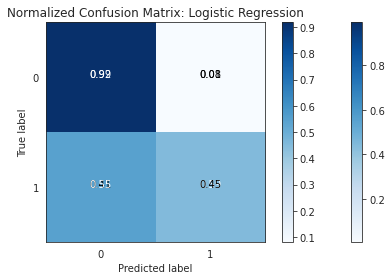

In [ ]:
# Baselines
print("----------------")
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_balanced, y_train_balanced)


y_predict_balanced = model.predict(X_test_balanced)
print(sum(y_predict_balanced == y_test_balanced))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test_balanced, y_predict_balanced)))
print(pd.DataFrame(confusion_matrix(y_test_balanced,y_predict_balanced)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test_balanced,y_predict_balanced),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')


print("----------------")
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train_balanced, y_train_balanced)


y_predict_balanced = model.predict(X_test_balanced)
print(sum(y_predict_balanced == y_test_balanced))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test_balanced, y_predict_balanced)))
print(pd.DataFrame(confusion_matrix(y_test_balanced,y_predict_balanced)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test_balanced,y_predict_balanced),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')


Next is MLP

In [ ]:
# over sampling with SMOTENC
# There exist categorical variable, so we use SMOTENC to do oversampling
from imblearn.over_sampling import SMOTENC
np.random.seed(1)
# To specify these are categorical features
smote_nc = SMOTENC(categorical_features=[0,1,2,5,6,7,8,11,12,13,14,15], random_state=1)
X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train, y_train)
X_test_balanced, y_test_balanced = smote_nc.fit_resample(X_test, y_test)

In [ ]:
#Initializing a random one
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'logistic',solver='sgd',random_state=1)
model.fit(X_train_balanced, y_train_balanced)

y_predict_balanced = model.predict(X_test_balanced)
print(sum(y_predict_balanced == y_test_balanced))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test_balanced, y_predict_balanced)))
print(pd.DataFrame(confusion_matrix(y_test_balanced,y_predict_balanced)))


10890
Accuracy Score is 0.50609
      0     1
0  9145  1614
1  9014  1745


In [ ]:
model = MLPClassifier(max_iter=300,random_state=1)

parameter_space = {
    'hidden_layer_sizes': [(10,25,50), (25,50,100), (10,50,100),(20,20,20),(100,50,20)], # each tuple is one construct...
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train_balanced, y_train_balanced)

print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (10, 25, 50, 150), 'learning_rate': 'constant', 'solver': 'adam'}
0.513 (+/-0.006) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 25, 50, 150), 'learning_rate': 'constant', 'solver': 'sgd'}
0.517 (+/-0.019) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 25, 50, 150), 'learning_rate': 'constant', 'solver': 'adam'}
0.513 (+/-0.006) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 25, 50, 150), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.517 (+/-0.019) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 25, 50, 150), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.519 (+/-0.007) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (25, 50, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
0.513 (+/-0.016) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (25, 50, 100), 'learning_rate

In [ ]:
#Best parameters found:
#{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (10, 50, 100), 'learning_rate': 'constant', 'solver': 'adam'}

model = MLPClassifier(hidden_layer_sizes=(10,50,100), max_iter=300,activation = 'relu',solver='adam',learning_rate='constant',alpha=0.05)
model.fit(X_train_balanced, y_train_balanced)

y_predict_balanced = model.predict(X_test_balanced)
print(sum(y_predict_balanced == y_test_balanced))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test_balanced, y_predict_balanced)))
print(pd.DataFrame(confusion_matrix(y_test_balanced,y_predict_balanced)))

12573
Accuracy Score is 0.5843
      0     1
0  2998  7761
1  1184  9575
